In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from datetime import datetime, timedelta
import re
import os
import joblib
import urllib
import json
from collections import defaultdict, Counter
from string import punctuation

from IPython.display import Image

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

import spacy
import en_core_web_sm

import requests
from newsapi.newsapi_client import NewsApiClient
import http.client
import aiohttp
import asyncio
import async_timeout
import nest_asyncio
import pyLDAvis.gensim

from wordcloud import WordCloud

nest_asyncio.apply()
pyLDAvis.enable_notebook()

In [2]:
from utils import *

In [3]:
# Set time window of a week
start = (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d')
end = datetime.today().strftime('%Y-%m-%d')

In [4]:
# Initialise NewsApiClient with an api key
newsapi =  NewsApiClient(api_key='344d14da92a541f7ae15eaa6b6ced22a')

query_terms = ['"Donald Trump"']
query = ' '. join(['(' + ' OR '.join([query for query in query_terms]) + ')'])

# Query for articles using keyword
all_articles = newsapi.get_everything(q=query,
                                     from_param=start,
                                     to=end,
                                     language='en',
                                     sort_by='relevancy',
                                     page_size=100)

In [5]:
# Extract articles from returned json and store in articles variable
articles = all_articles['articles']
# Convert articles into dataframe
articles_df = pd.DataFrame(articles)
# Use only name part in the source columns
articles_df['source'] = articles_df.source.map(lambda x:x['name'])
# Select relevant columns for analysis
articles_df = articles_df[['source', 'title', 'url', 'publishedAt', 'content']]
articles_df.columns = ['Source', 'Title', 'Url', 'Published', 'Content']

In [6]:
articles_df.head()

,Source,Title,Url,Published,Content
0,Wired,How to Watch the First 2020 Presidential Debate,https://www.wired.com/story/how-to-watch-the-f...,2020-09-28T18:29:40Z,The first presidential debate between Donald T...
1,New York Times,Does Donald Trump Need a Bailout?,https://www.nytimes.com/2020/09/28/opinion/tru...,2020-09-29T00:36:13Z,"Coats, wrote Woodward, thought Putin had somet..."
2,New York Times,Donald Trump Burns the First Debate Down,https://www.nytimes.com/2020/09/30/arts/televi...,2020-09-30T13:27:32Z,"The last four years, you have promised to repe..."
3,New York Times,Donald Trump Was the Real Winner of ‘The Appre...,https://www.nytimes.com/2020/09/28/arts/televi...,2020-09-28T19:50:46Z,Thats where you see Mr. Trump in the shows ver...
4,CNN,Analysis: Trump's taxes reveal why he really r...,https://www.cnn.com/2020/09/28/politics/donald...,2020-09-28T13:57:16Z,THE POINT -- NOW ON YOUTUBE! \r\nIn each episo...


In [7]:
# Initialize ContentEtractor class and pass url columns as argument
# Store result dataframe into full_content_df varibale returned by content_to_dataframe method
content_extractor = ContentExtractor(articles_df['Url'])
full_content_df = content_extractor.content_to_dataframe()
# combine original dataframe with full content dataframe
combined_df = pd.concat([articles_df, full_content_df], axis=1)

In [8]:
# Initialize ContentFilter class and pass combined dataframe as argument.
# call filter_content method for class instance
# store result into filtered_df varibale
# display first 5 rows of result dataframe
content_filter = ContentFilter(combined_df)
filtered_df = content_filter.filter_content()
filtered_df.head()

,Source,Title,Url,Published,Content,Text,Keywords
0,Wired,How to Watch the First 2020 Presidential Debate,https://www.wired.com/story/how-to-watch-the-f...,2020-09-28T18:29:40Z,The first presidential debate between Donald T...,The first presidential debate between Donald T...,"[youre, channels, debate, debates, 2020, healt..."
1,New York Times,Does Donald Trump Need a Bailout?,https://www.nytimes.com/2020/09/28/opinion/tru...,2020-09-29T00:36:13Z,"Coats, wrote Woodward, thought Putin had somet...",To hear more audio stories from publishers lik...,"[president, does, opinion, vladimir, united, n..."
2,New York Times,Donald Trump Burns the First Debate Down,https://www.nytimes.com/2020/09/30/arts/televi...,2020-09-30T13:27:32Z,"The last four years, you have promised to repe...","“The last four years, you have promised to rep...","[think, youre, tax, debate, know, ballots, say..."
3,New York Times,Donald Trump Was the Real Winner of ‘The Appre...,https://www.nytimes.com/2020/09/28/arts/televi...,2020-09-28T19:50:46Z,Thats where you see Mr. Trump in the shows ver...,Donald J. Trump’s greatest success as a busine...,"[unprofitable, turns, apprentice, mr, world, w..."
4,CNN,Analysis: Trump's taxes reveal why he really r...,https://www.cnn.com/2020/09/28/politics/donald...,2020-09-28T13:57:16Z,THE POINT -- NOW ON YOUTUBE! \r\nIn each episo...,(CNN) Donald Trump needed a new act.\n\nBy 201...,"[brand, president, way, york, returns, really,..."


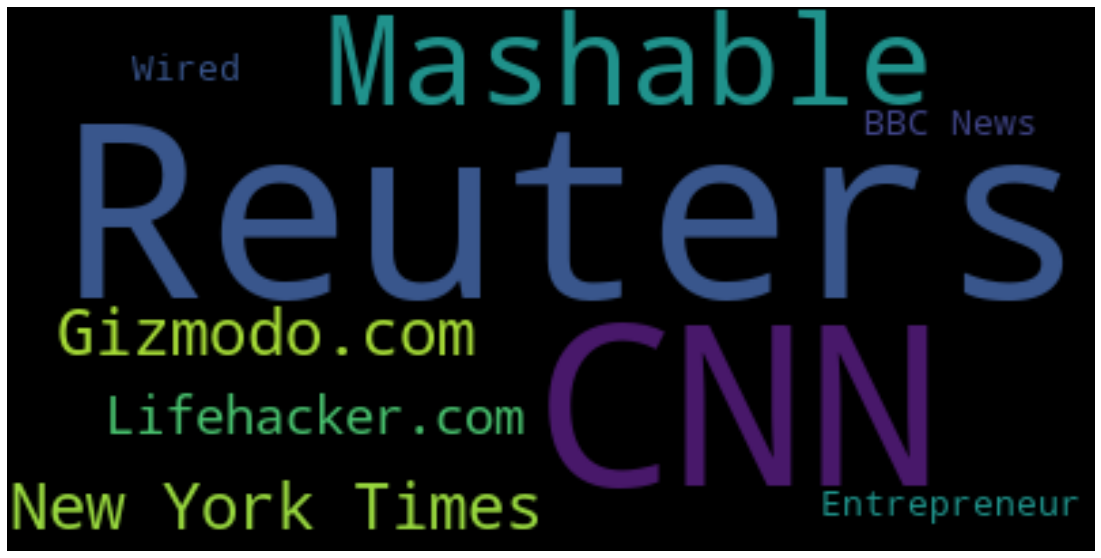

In [9]:
sources_dict = filtered_df.Source.value_counts().to_dict()
w = WordCloud(background_color='black').generate_from_frequencies(sources_dict)
plt.figure(figsize=(20,10))
plt.imshow(w, interpolation='bilinear')
plt.axis('off')
plt.show();

In [10]:
# Initialize TopicModeler class and pass filtered_df as argument
# Call generate_dominant_topic method on class instance and store result dataframe into df_dominant_topic variable.
topic_generator = TopicModeler(filtered_df)
df_dominant_topic, optimal_model, corpus = topic_generator.generate_dominant_topic()
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contribution,Topic_Keywords,Clean_Text,Published,Source,Text,Keywords,Url
0,0,4.0,0.995,"president, trump, debate, speedy_recovery, liv...","[first, presidential, debate, donald, trump, j...",2020-09-28T18:29:40Z,Wired,The first presidential debate between Donald T...,"[youre, channels, debate, debates, 2020, healt...",https://www.wired.com/story/how-to-watch-the-f...


In [11]:
# Visualization of topic using pyLDAvis library
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary=optimal_model.id2word)

In [12]:
# Create a dataframe that has Dominant topic number as index and associated topic keywords and
# number of documents with that topic as columns
topic_dist = pd.concat([df_dominant_topic[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
                        .sort_values('Dominant_Topic').set_index('Dominant_Topic'), df_dominant_topic['Dominant_Topic'].
                       value_counts().sort_index()], axis=1)
topic_dist.columns = ['Topic_Keywords', 'Num_Document']
topic_dist.index.name = 'Dominant_Topic'
topic_dist.reset_index(inplace=True)

In [13]:
# create a dataframe with topic and 5 words for that topic
topic_top5words = [(int(row.Dominant_Topic), topic) for _, row in topic_dist.iterrows() for j, topic in 
                   enumerate(row.Topic_Keywords.rsplit(', ')) if j < 5]
df_top5words_stacked = pd.DataFrame(topic_top5words, columns=['tpoic_id', 'words'])
df_top5words = df_top5words_stacked.groupby('topic_id').agg(', \n'.join)

# Plot bar chart showing most discussed topic in documents
fig, ax = plt.subplots(figsize=(18,8))
ax.bar(x='Dominant_Topic', height='Num_Document', data=topic_dist, width=.5, color='firebrick')
ax.set_xticks(df_top5words.index)
tick_formatter = FuncFormatter(lambda x, pos: 'Topic' + str(x) + '\n\n' + df_top5words['words'][x])
ax.xaxis.set_major_formatter(tick_formatter)
ax.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax.set_ylabel('Number of Documents', fontdict=dict(size=12))
ax.set_xlabel('\nTopic Number and 5 keywords', fontdict=dict(size=12))
ax.set_ylim(0, max(topic_dist.Num_Document)+1);

KeyError: 'topic_id'

In [14]:
# Select documents with appropriate topic and store result dataframe into relevant_news variable
relevant_news = df_dominant_topic[['Published', 'Source', 'Text', 'Clean_Text', 'Title', 'Url']]
# Drop row with duplicate article text
relevant_news = relevant_news.drop_duplicates(subset=['Text'], ignore_index=True)

KeyError: "['Title'] not in index"

In [15]:
top_10 = []
counterparties = [person.strip('"').lower() for person in top_10]
def extract_person_entity(article):
    """
    This function uses spacy model to list person entity recognized in the article text.
    """
    nlp = en_core_web_sm.load()
    doc = nlp(article)
    people = [X.text for X in doc.ents if (X.label_ == 'PER')]
    exclude = []
    people = [x for x in people if x.lower() not in exclude]
    counterparty_found = list({person for person in people if person.lower() in counterparties})
    return counterparty_found

In [16]:
# Call exxtract_org_entity function on each text for relevant news dataframe and create a column 'Entities' from reulsting
# list of person entities
relevant_news['Entities'] = relevant_news.Text.map(extract_person_entity)
relevant_news.to_csv('relevant_news.csv', index=False)

NameError: name 'relevant_news' is not defined

In [17]:
relevant_news = pd.read_csv('relevant_news.csv')
sentiment_analyzer = SentimentAnalyzer(relevant_news, 'Clean_Text')
predictions = sentiment_analyzer.news_to_dataframe()

FileNotFoundError: [Errno 2] No such file or directory: 'relevant_news.csv'

In [18]:
pos_df = predictions[predictions['Sentiment'] == 1]
neg_df = predictions[predictions['Sentiment'] == -1]

def get_text(df):
    texts = []
    exclude_list = [] + counterparties
    for content in df['Clean_Text']:
        word_list = content.strip("][").split(', ')
        word_list = [word.strip("''") for word in word_list]
        content = [word for word in word_list if word not in exclude_list]
        texts.append(' '.join(content))
    return texts

pos_text = get_text(pos_df)
neg_text = get_text(neg_df)

def generate_wordcloud(text):
    vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2, max_features=100)
    tdm = vectorizer.fit_transform(text)
    freqs = [(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
    word_dict = {}
    for word_weight in freqs:
        word_dict[word_weight[0]] = word_weight[1]
    
    w = WordCloud(background_color='black').generate_from_frequencies(word_dict)
    plt.figure(figsize=(20,10))
    plt.imshow(w, interpolation='bilinear')
    plt.axis('off')
    plt.show();

NameError: name 'predictions' is not defined

In [19]:
generate_wordcloud(pos_text)

NameError: name 'generate_wordcloud' is not defined

In [20]:
generate_wordcloud(neg_text)

NameError: name 'generate_wordcloud' is not defined